In [31]:
import numpy as np
import pandas as pd
import re
import json
from tqdm.notebook import trange, tqdm
import socket

import nltk
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random
from math import ceil

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
import pyspark.sql.functions as func
from pyspark.sql.types import *
from pyspark import StorageLevel

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

## Download the model and vocabulary


In [4]:
vocabulary_path = r'./vocabulary.json'
with open(vocabulary_path, "r") as f:
    vocab = json.load(f)

In [5]:
class FakeNewsDetector(nn.Module):
    def __init__(self, num_embeddings=len(vocab), embedding_dim=256, hidden=[128, 128, 64, 8, 1]):
        super().__init__()
        self.hidden = hidden
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=1)
        self.conv1d_1 = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=self.hidden[0], kernel_size=3, stride=1),
            nn.BatchNorm1d(self.hidden[0]),
            nn.SiLU(),
            nn.Conv1d(in_channels=self.hidden[0], out_channels=self.hidden[1], kernel_size=3, stride=1),
            nn.BatchNorm1d(self.hidden[1]),
            nn.SiLU(),
            nn.MaxPool1d(2)
        )
        self.conv1d_2 = nn.Sequential(
            nn.Conv1d(in_channels=self.hidden[1], out_channels=self.hidden[2], kernel_size=1, stride=1),
            nn.BatchNorm1d(self.hidden[2]),
            nn.SiLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(input_size=self.hidden[2], hidden_size=self.hidden[3], num_layers=1, batch_first =True, bidirectional =True)
        self.fn_act = nn.Tanh()
        
        self.flatten = nn.Flatten()
        lstm_out_dim = 255 * self.hidden[3] * 2
        self.linear = nn.Linear(lstm_out_dim, self.hidden[4])
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(-1, -2)
        
        x = self.conv1d_1(x)
        x = self.conv1d_2(x)
        
        x = x.transpose(-1, -2)
        x, _ = self.lstm(x)
        x = self.fn_act(x)
        
        x = self.flatten(x)
        x = self.linear(x)
        
        return x

In [6]:
state_dict = torch.load("drive/MyDrive/BD_project/FakeNewsDetector_model.tar", map_location=torch.device(device))

def get_model_for_eval():
    model = FakeNewsDetector()
    model.load_state_dict(state_dict)
    model.eval()
    return model

## Preparing data-cleaning functions

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer() #lemmatization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data processing

In [95]:
data_path = r'/news_data_combined.csv'
LOCAL_IP = socket.gethostbyname(socket.gethostname())

spark = (
    SparkSession
    .builder
    .appName('project')
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host', LOCAL_IP)
    .config('spark.driver.bindAddres', '0.0.0.0')
    .config('spark.executor.instances', '2')
    .config('spark.executos.cores', '2')
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '4g')
    .config('spark.sql.execution.arrow.enabled', 'true')
    .config("spark.ui.showConsoleProgress", "true")
    .config('spark.kubernetes.namespace', 'agurov-337411')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:agurov-337411')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermination', 'false')
    .getOrCreate()
)
df_sp = spark.read.option("header",True).option("header",True).option("delimiter", ";").csv(data_path)
print(f"All rows count: {df_sp.count()}")

All rows count: 347545


In [96]:
df_sp.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- title: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- fulltext: string (nullable = true)
 |-- date: string (nullable = true)



In [97]:
df_info = df_sp.withColumn("date", func.to_date(func.col("date"), "yyyy-MM-dd")).withColumn("id", func.monotonically_increasing_id())

In [10]:
df_sp = df_info.filter(~df_info.fulltext.isNull()).drop("_c0", "url")
print(f"Not null rows count: {df_sp.count()}")

Not null rows count: 340559


In [158]:
def procces_text(data):
    all_processed_text = []
    for text in data:
        text = re.sub("[^a-zA-Z]", " ",text)
        text = text.lower()
        text = [word for word in nltk.word_tokenize(text) if not word in stop_words]
        text = [lemmatizer.lemmatize(token) for token in text]
        all_processed_text.append(text)
    
    return pd.Series(all_processed_text)

procces_text_UDF = func.pandas_udf(procces_text, ArrayType(StringType()))

In [13]:
df_sp = df_sp.withColumn("text_processed", procces_text_UDF(func.col("fulltext")))\
               .drop("fulltext", "title", "url", "source_id", "date")

In [14]:
def word2vec_apply(mapping):
    def word2vec_vocab(words):
        vector = []
        for word in words:
            try:
                embedding = mapping[word]
                vector.append(embedding)
            except:
                pass
        if len(vector) < 1024 and len(vector) > 5:
            vector += [1 for i in range(1024 - len(vector))]
        else:
            vector = [1] 
        return vector
    return func.udf(word2vec_vocab, ArrayType(IntegerType()))

In [15]:
df_sp = df_sp.withColumn("text_vector", word2vec_apply(vocab)(func.col("text_processed")))
df_sp = df_sp.filter(func.size(func.col("text_vector")) == 1024).drop("text_processed")

## Feew forward data through the model

In [16]:
class EvaluationData(torch.utils.data.Dataset):
    def __init__(self, text):
        super().__init__()
        self.text = text
        
    def __getitem__(self, idx):
        item = self.text[idx]
        return item
    
    def __len__(self):
        return self.text.shape[0]

In [17]:
def predict_batch(data):
    dataset = EvaluationData(np.array(list(data)))
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, drop_last=False)

    data_model = get_model_for_eval()
    data_model.to(device)
    all_predictions = []
    with torch.no_grad():
        for batch in data_loader:
            data_inputs = batch.to(device)
            predictions = data_model(data_inputs)
            predictions = predictions.squeeze(dim=1)
            predictions = torch.sigmoid(predictions)
            pred_labels = (predictions >= 0.5).long().cpu().numpy()
            for label in pred_labels:
                all_predictions.append(label)
    return pd.Series(all_predictions)

predict_batch_UDF = func.pandas_udf(predict_batch, IntegerType())

In [18]:
df_sp = df_sp.withColumn("is_truth", predict_batch_UDF(func.col("text_vector"))).drop("text_vector")

In [19]:
df_fakes_id = df_sp.filter(func.col("is_truth") == 0).select("id")
df_fakes_id = df_fakes_id.persist()

## Results visualization

In [ ]:
df_fakes_id_list = df_fakes_id.select("id").rdd.flatMap(lambda x: x).collect()
df_info = df_info.drop("_c0", "url")
df_fake = df_info.filter(df_info.id.isin(df_fakes_id_list))

In [103]:
df_fake.count()

19247

In [105]:
df_fake.show()

+--------------------+--------------------+--------------------+----------+---+
|               title|           source_id|            fulltext|      date| id|
+--------------------+--------------------+--------------------+----------+---+
|Niall Ferguson: B...|       Bloomberg.com|Why did this happ...|2022-01-01|  2|
|Ansaru reaffirms ...|    Long War Journal|Al Qaeda's franch...|2022-01-01|  9|
|2022 Look Ahead: ...|           Arab News|MISSOURI  WASHING...|2022-01-01| 10|
|Florida housed th...|     Palm Beach Post|On June 6 1944 a ...|2022-01-01| 11|
|A year after the ...|           The Times|On Christmas Eve ...|2022-01-01| 13|
|Finland insists o...|     Financial Times|What is the futur...|2022-01-01| 16|
|How the 'Global W...|The National Inte...|The Global War on...|2022-01-01| 17|
|How To Find The H...|            TheGamer|Collectibles in G...|2022-01-01| 20|
|Swig, Sodalicious...|        Deseret News|We don't do every...|2022-01-01| 23|
|Five of world’s m...|        The Guardi

In [ ]:
import functools
def fudf(val):
    return functools.reduce(lambda x, y:x+y, val)
flattenUdf = func.udf(fudf, StringType())

def fusion_words(val):
    string = " "
    for words in val:
        string += words
    return string
fusion_wordsUDF = func.udf(fusion_words, StringType())

In [110]:
df_days = df_fake.groupBy("date").count().toPandas()
df_source = df_fake.groupBy("source_id").count().toPandas()

df_fake_words = df_fake.groupBy(func.month(df_fake.date).alias("month")).agg(func.collect_list(func.col("title")).alias("words"))
df_fake_words = df_fake_words.select("month", fusion_wordsUDF(func.col("words")))
df_fake_words = df_fake_words.toPandas()
df_fake_words = df_fake_words.sort_values("month")

In [183]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('ggplot')


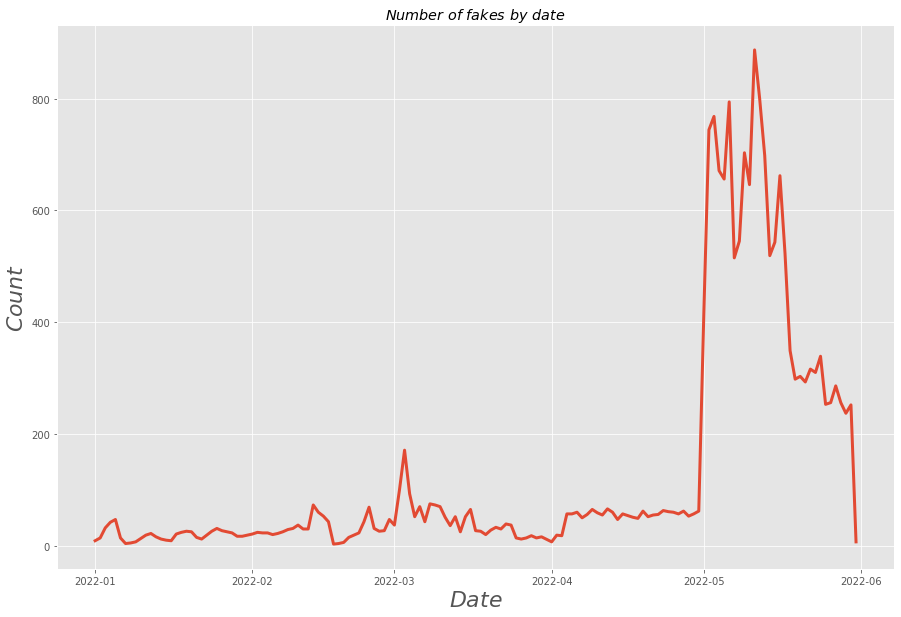

In [191]:
save_path = r'./'

ax = plt.subplot()
ax.plot(df_days.sort_values("date").date, df_days.sort_values("date")["count"], linewidth = 3)
ax.set_xlabel(r'$Date$', fontsize=22)
ax.set_ylabel(r'$Count$', fontsize=22)
ax.set_title('$Number~of~fakes~by~date$')
plt.savefig(save_path + r"fakes_date.png", dpi=300)

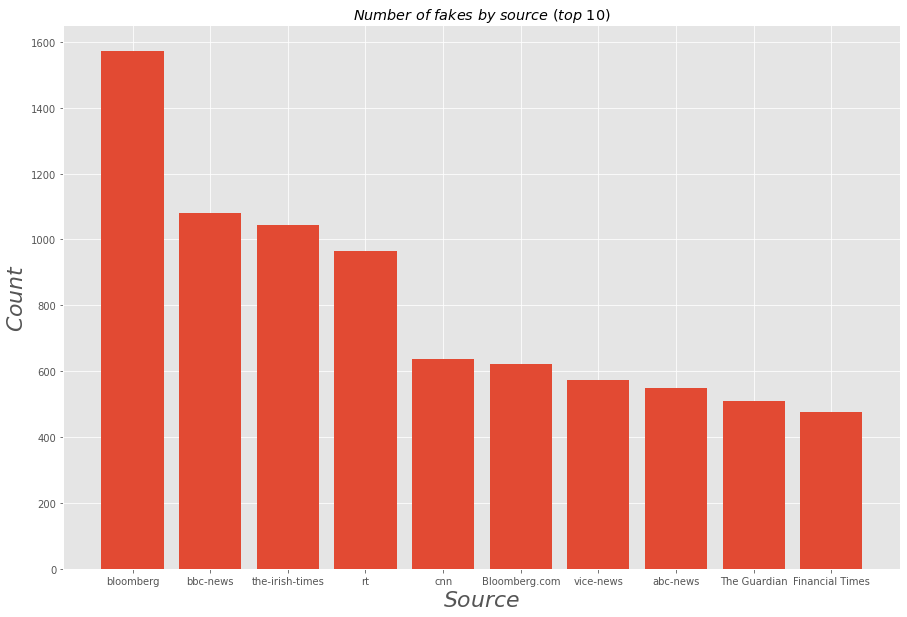

In [192]:
ax = plt.subplot()
ax.bar(df_source.sort_values("count", ascending=False)[:10]["source_id"], df_source.sort_values("count", ascending=False)[:10]["count"])
ax.set_xlabel(r'$Source$', fontsize=22)
ax.set_ylabel(r'$Count$', fontsize=22)
ax.set_title('$Number~of~fakes~by~source~(top~10)$')
plt.savefig(save_path + r"fakes_source.png", dpi=300)

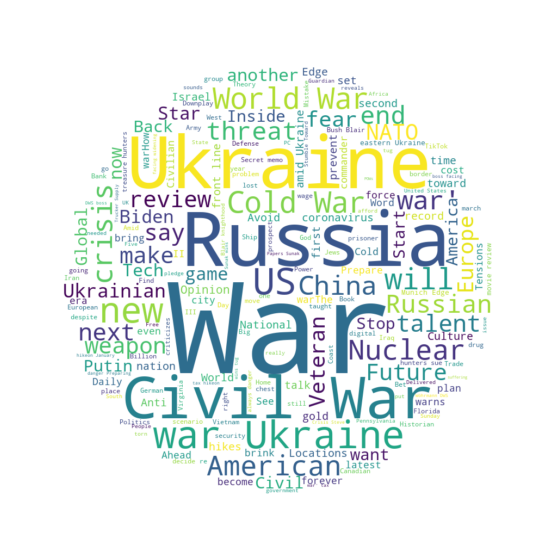

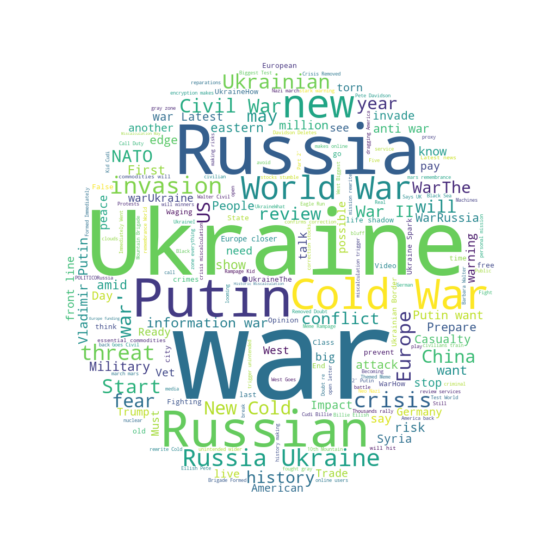

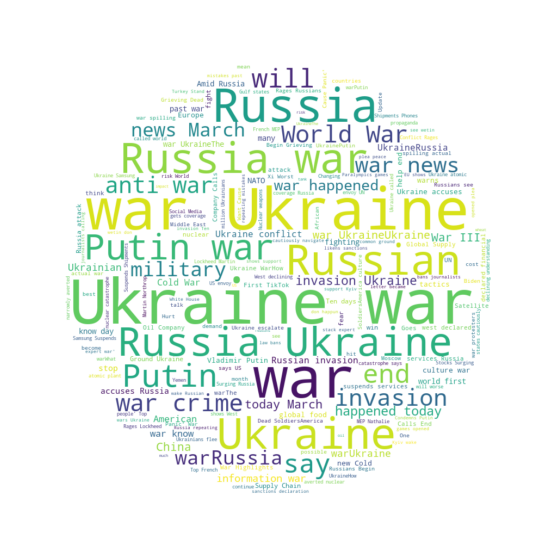

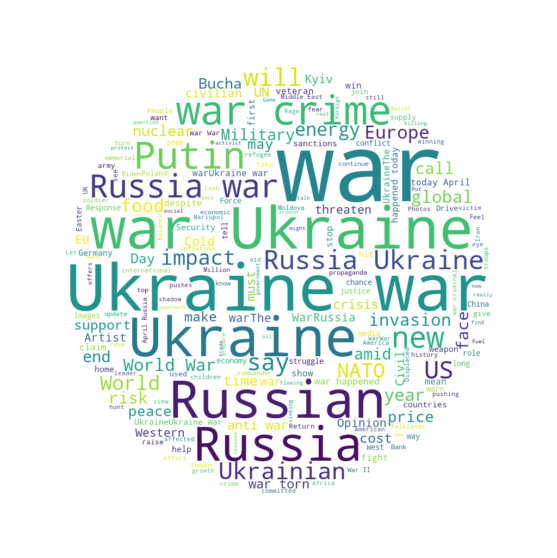

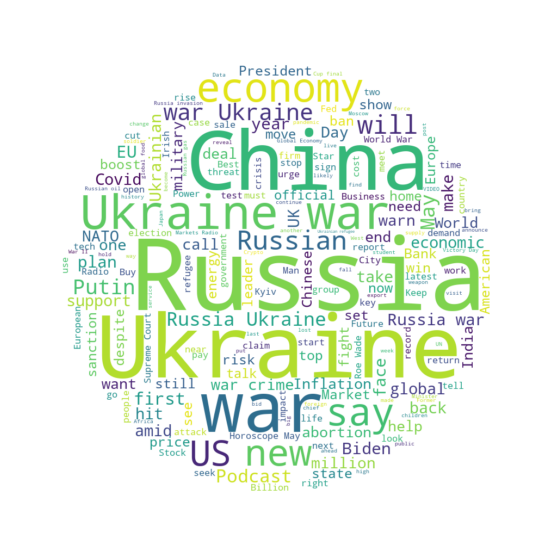

In [200]:
x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

for i in range(df_fake_words.shape[0]):
    fig, ax = plt.subplots()
    wordcloud = WordCloud(background_color="white", width=1920, height=1080, mask=mask).generate(df_fake_words.iloc[i, 1])
    ax.axis("off")
    ax.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(save_path + r"fakes_words_" + str(i) + ".png", dpi=300)